In [1]:

import kwant
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import scipy.sparse.linalg as sla
from scipy.linalg import eig
import scipy   
from itertools import cycle
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec
import matplotlib.colors as colors
import matplotlib as mpl
import sys, os 


In [2]:

sigma = np.array([[[0, 1], [1, 0]],
                  [[0, 1j], [-1j, 0]],
                  [[1, 0], [0, -1]],
                  [[1, 0],[0, 1]]])


lat_h = kwant.lattice.chain(norbs=1)
bulk_h = kwant.Builder(symmetry=kwant.lattice.TranslationalSymmetry([2]))

lat_a = kwant.lattice.chain(norbs=1)
bulk_a = kwant.Builder(symmetry=kwant.lattice.TranslationalSymmetry([2]))


In [15]:
#HERE I HAVE TO ADD THE ANTIHERMITIAN PART AND THEN SUM THEM TOGETHER 


def onsite_h(site):
    return 0

def hopping_hintra(site1, site2, t1):
    return t1

def hopping_hinter(site1, site2, t2):
    return t2

bulk_h[lat_h(0)] = onsite_h
bulk_h[lat_h(1)] = onsite_h
bulk_h[lat_h(0),lat_h(1)] = hopping_hintra
bulk_h[lat_h(1),lat_h(2)] = hopping_hinter

def onsite_a(site):
    return 0 

def hopping_aintra(site1, site2, v1):
    return 1j*v1

bulk_a[lat_a(0)] = onsite_a
bulk_a[lat_a(1)] = onsite_a
bulk_a[lat_a(0),lat_a(1)] = hopping_aintra
bulk_a[lat_a(1),lat_a(2)] = 0



finite_h = kwant.Builder()
finite_a = kwant.Builder()

L = 49

def shape(site):
    pos=site.pos
    return 0<=pos[0]<L

finite_h.fill(bulk_h, shape, start=[0]);
finite_a.fill(bulk_a, shape, start=[0]);

finite_h = finite_h.finalized()
finite_a = finite_a.finalized()


KeyboardInterrupt: 

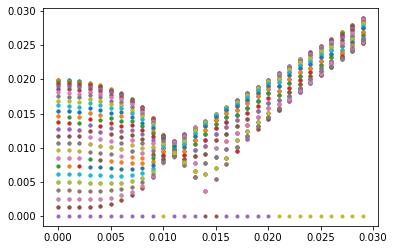

In [16]:
t1=0.01
gamma_r = np.arange(0,3*t1,0.001)
E = []
for aux in gamma_r:
    params_h1 = dict(t1=0.01, t2=0.01)
    ham_h1 = finite_h.hamiltonian_submatrix(params = params_h1)
    params_a1 = dict(v1=aux)
    ham_a1 = finite_a.hamiltonian_submatrix(params = params_a1)
    hamiltonian1 = ham_h1 + 1j*ham_a1  
    eigvals1, eigvecL1, eigvecR1 = eig(hamiltonian1, left=True, right=True)
    E.append(eigvals1)
    
E = np.array(E) 
plt.plot(gamma_r,np.abs(E),'.')
raise KeyboardInterrupt

norm1 = np.diag(eigvecL1.conj().T @ eigvecR1)

eigvecR1 = eigvecR1/norm1

P1 = np.zeros((20,20))

#HERE WE HAVE TO CHANGE DEFINITION OF P1 TO MAKE IT BIORTHOGONAL

P1 = (eigvecL1) @ np.diag(eigvals1 < 0.1) @ eigvecR1.conj().T

x = np.diag([s.pos[0] for s in finite_h.sites])
print(x)
X1 = P1@x@P1
print(X1.shape)

evals1, evecs1 = np.linalg.eig(X1)
print(evals1.shape)
#print(evals1)

evals1 = evals1[evals1 > 0]

order1 = np.argsort(evals1)


In [51]:

params_h2 = dict(t1=1, t2=100)
ham_h2 = finite_h.hamiltonian_submatrix(params = params_h2)
params_a2 = dict(v1=10)
ham_a2 = finite_a.hamiltonian_submatrix(params = params_a2)


hamiltonian2 = ham_h2 + 1j*ham_a2

eigvals2, eigvecL2, eigvecR2 = eig(hamiltonian2, left=True, right=True)


norm2 = np.diag(eigvecL2.conj().T @ eigvecR2)

eigvecR2 = eigvecR2/norm2
P2 = np.zeros((20,20))
P2 = (eigvecL2) @ np.diag(eigvals2 < 0.1) @ eigvecR2.conj().T

X2 = P2@x@P2
evals2, evecs2 = np.linalg.eig(X2)

#print(evals2)
evals2 = evals2[evals2 > 0]
order2 = np.argsort(evals2)


np.allclose(eigvecL2.T.conj() @ eigvecR2, np.eye(evecs2.shape[0]))


True

In [54]:

plt.scatter(evals1[order1], np.zeros((len(evals1), )), c = 'b')
    
plt.scatter(evals2[order2], np.zeros((len(evals2), )), c = 'r')    

y = np.zeros(20)
for i in range(20):
    y[i] = 0.0005


plt.scatter([s.pos[0] for s in finite_h.sites], y, c = 'y')

red_patch = mpatches.Patch(color='red', label='t2 > t1')
blue_patch = mpatches.Patch(color='blue', label='t1 > t2')
yellow_patch = mpatches.Patch(color='yellow', label = 'sites')

plt.title('nH-SSH chain, projected position operator (no additional terms)')
plt.legend(handles=[blue_patch, red_patch, yellow_patch])




In [12]:

########T1>>T2
#f=0.1
ev = []
colors = iter(cm.plasma(np.linspace(0, 1, 50)))
for aux in np.linspace(0,np.pi/2,50):
    params_h1 = dict(t1=np.sin(aux), t2=np.cos(aux))
    ham_h1 = finite_h.hamiltonian_submatrix(params = params_h1)
    params_a1 = dict(v1=0.1)
    ham_a1 = finite_a.hamiltonian_submatrix(params = params_a1)
    hamiltonian1 = ham_h1 + 1j*ham_a1  
    eigvals1, eigvecL1, eigvecR1 = eig(hamiltonian1, left=True, right=True)
    order = np.argsort(eigvals1.real)                                        
    #ev.append(eigvals1[order])

    col = next(colors)
    for e in eigvals1[order]:
        plt.plot(e.real, e.imag, 'x', c=col)
        plt.xlabel('Re(E)')
        plt.ylabel('Im(E)')
        #plt.title('d='+str(f))
    plt.savefig("/Users/albertozorzato/Desktop/Plots/Porcodio"+str(i)+".png")     
    #f=round(f+0.1,1) this would be for incrementing v1
    i=i+1
    plt.close


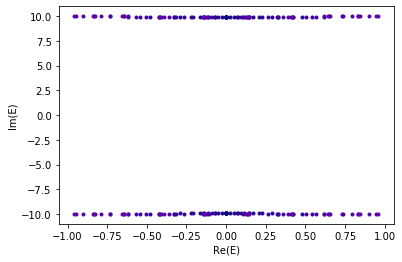

In [9]:
##########THIS IS FOR THE SETTING IN WHICH T2>>>>T1

ev = []
colors = iter(cm.plasma(np.linspace(0, 1, 50)))
for aux in np.linspace(0,np.pi/2,10):
    params_h2 = dict(t1=np.cos(aux), t2=np.sin(aux))
    ham_h2 = finite_h.hamiltonian_submatrix(params = params_h2)
    params_a1 = dict(v1=0.1)
    ham_a2 = finite_a.hamiltonian_submatrix(params = params_a2)
    hamiltonian2 = ham_h2 + 1j*ham_a2  
    eigvals2, eigvecL2, eigvecR2 = eig(hamiltonian2, left=True, right=True)
    order = np.argsort(eigvals2.real)                                        


    col = next(colors)
    for e in eigvals2[order]:
        plt.plot(e.real, e.imag, '.', c = col)
        plt.xlabel('Re(E)')
        plt.ylabel('Im(E)')

        

In [10]:

%%time
#############THIS IS FOR PLOTTING SEQUENCES###################


i=0
for aux in np.linspace(0,np.pi/2,50):    
    params_h1 = dict(t1=np.sin(aux), t2=np.cos(aux))
    ham_h1 = finite_h.hamiltonian_submatrix(params = params_h1)
    params_a1 = dict(v1=0.1)
    ham_a1 = finite_a.hamiltonian_submatrix(params = params_a1)
    hamiltonian1 = ham_h1 + 1j*ham_a1  
    eigvals1, eigvecL1, eigvecR1 = eig(hamiltonian1, left=True, right=True)
    order = np.argsort(eigvals1.real)    
    
    for e in eigvals1[order]:
        fig = plt.plot(e.real, e.imag, 'x', c='red')
        plt.title('0<=t1<=2, t2=1, d=0.1')
        plt.xlabel('Re(E)')
        plt.ylabel('Im(E)')
        plt.ylim(-1,1) 
    plt.savefig("/Users/albertozorzato/Desktop/Plots/Porcodio"+str(i)+".png") 
    i = i+1
    plt.close()    
    
    
    

CPU times: user 13.5 s, sys: 465 ms, total: 14 s
Wall time: 11.4 s


In [11]:
######PLOTTING TRICKS BY CHRISTOPH#######

mpl.use('Qt5Agg')
os.environ["PATH"] += ':/usr/local/texlive/2015/bin/x86_64-darwin'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.tick_params(labelsize=20)


SMALL_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)



def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def color(r):
	return plt.cm.hsv(r)

plot_list = np.arange(0.0,0.7,0.05)

fig= plt.figure()
gs = GridSpec(1, 2, figure=fig,wspace=0.05,width_ratios=[16, 1])
fig.set_figheight(5)
fig.set_figwidth(6.3)

color_min=0.7
color_max=1.0

r_l=np.linspace(color_min,color_max,num=len(plot_list))

ax1 = fig.add_subplot(gs[0])
ax1_2=fig.add_subplot(gs[1])


cmap=plt.get_cmap('hsv')
new_cmap = truncate_colormap(cmap, minval=color_min, maxval=color_max, n=100)
norm = mpl.colors.Normalize(vmin=plot_list[0], vmax=plot_list[-1])

cb1 = mpl.colorbar.ColorbarBase(ax1_2, cmap=new_cmap,norm=norm,orientation='vertical')
cb1.set_label('$ t_1 $',rotation=0,fontsize=16,labelpad=-5,y=1.0)

for aux in np.linspace(0,np.pi/2,50):    
    params_h1 = dict(t1=np.sin(aux), t2=np.cos(aux))
    ham_h1 = finite_h.hamiltonian_submatrix(params = params_h1)
    params_a1 = dict(v1=0.1)
    ham_a1 = finite_a.hamiltonian_submatrix(params = params_a1)
    hamiltonian1 = ham_h1 + 1j*ham_a1  
    eigs, eigvecL1, eigvecR1 = eig(hamiltonian1, left=True, right=True)
    order = np.argsort(eigs.real)  
    for e in eigs[order]:
        ax1.plot(eigs.real,eigs.imag,'.',color=color(r_l[j]))
    
    ax1.set_xlabel('$ \\mathrm{Re}(E) $')
    ax1.set_ylabel('$ \\mathrm{Im}(E) $')
        
plt.show()



AttributeError: 'iterator' object has no attribute 'LinearSegmentedColormap'